# Shapley Values: California Housing Example

This notebook demonstrates the `shapley_values` package on a real tabular dataset:
the **California Housing** dataset from scikit-learn.

**Goal:** Quantify how much each feature contributes to a trained model's predictions
using exact Shapley values from cooperative game theory.

**Setup:**
- **Players** = the 8 housing features (MedInc, HouseAge, AveRooms, ...)
- **Model** = a single Random Forest trained on all features (no retraining)
- **Value function** $v(S)$ = $R^2$ when only features in $S$ are observed and absent features are **marginalized** over background samples drawn from the training set
- **Shapley value** $\phi_i$ = the fair attribution of feature $i$ to overall model performance

$$
\phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!\,(|N|-|S|-1)!}{|N|!}\;\bigl[v(S \cup \{i\}) - v(S)\bigr]
$$

With 8 features we enumerate all $2^8 = 256$ coalitions: fast and exact.

In [14]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from shapley_values import (
    ExactShapley,
    plot_shapley_bar,
    plot_shapley_pie,
    plot_shapley_comparison,
    plot_marginal_contributions,
    save_results,
    load_results,
)

## 1. Load and split the data

The California Housing dataset contains **20,640 samples** and **8 numeric features**.
The target is the median house value (in $100k) for each census block group.

In [15]:
data = fetch_california_housing(as_frame=True)
X, y = data.data, data.target
feature_names = list(X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Features ({len(feature_names)}): {feature_names}")
print(f"Train: {X_train.shape[0]:,}  |  Test: {X_test.shape[0]:,}")
X.describe().round(2)

Features (8): ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Train: 16,512  |  Test: 4,128


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00
mean,3.87,28.64,5.43,1.10,1425.48,3.07,35.63,-119.57
std,1.90,12.59,2.47,0.47,1132.46,10.39,2.14,2.00
min,0.50,1.00,0.85,0.33,3.00,0.69,32.54,-124.35
25%,2.56,18.00,4.44,1.01,787.00,2.43,33.93,-121.80
50%,3.53,29.00,5.23,1.05,1166.00,2.82,34.26,-118.49
75%,4.74,37.00,6.05,1.10,1725.00,3.28,37.71,-118.01
max,15.00,52.00,141.91,34.07,35682.00,1243.33,41.95,-114.31


## 2. Train a Random Forest (once)

We train a single `RandomForestRegressor` on **all** features.
This is the only model we train -- all subsequent Shapley value computations
use this model for **inference only** (no retraining).

In [16]:
rf_full = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_full.fit(X_train, y_train)

r2_full = r2_score(y_test, rf_full.predict(X_test))
print(f"Full-model R2 = {r2_full:.4f}")

Full-model R2 = 0.8051


## 3. Define the value function (inference only)

We use the **single trained Random Forest** from above -- no retraining.
For a coalition $S$, absent features are replaced by their **training-set mean**
(mean imputation):

$$v(S) = R^2\!\Bigl(y_{\text{test}},\; f\bigl(x_S,\, \bar{x}_{\bar{S}}\bigr)\Bigr)$$

- Features in $S$: keep their real test values.
- Features **not** in $S$: set to the training mean $\bar{x}_j$.

If the coalition is empty, every feature is set to its mean and the model
outputs a constant prediction, giving $R^2 \approx 0$.

In [17]:
# Training-set mean (used to fill absent features)
X_mean = X_train.mean()  # Series with feature names
n_features = len(feature_names)

def value_fn(coalition):
    """R2 of rf_full when only features in `coalition` are observed.
    Absent features are replaced by their training-set mean."""
    X_aug = pd.DataFrame(
        np.tile(X_mean.values, (len(X_test), 1)),
        columns=feature_names,
    )
    if len(coalition) > 0:
        cols = [feature_names[i] for i in coalition]
        X_aug[cols] = X_test[cols].values
    return r2_score(y_test, rf_full.predict(X_aug))

# Quick sanity check
print(f"v(empty)         = {value_fn([]):.4f}")
print(f"v({{MedInc}})      = {value_fn([0]):.4f}")
print(f"v({{all}})         = {value_fn(list(range(n_features))):.4f}")

v(empty)         = -1.1027
v({MedInc})      = -0.0639
v({all})         = 0.8051


## 4. Compute exact Shapley values

We create an `ExactShapley` object and call `compute()`.
This enumerates all $2^8 = 256$ coalitions and evaluates the value function for each.

In [13]:
sv = ExactShapley(
    n_players=len(feature_names),
    value_function=value_fn,
    player_labels=feature_names,
)

results = sv.compute(verbose=True)

Computing exact Shapley values for 8 players (256 coalitions)...
Baseline (empty coalition) = -1.102675

  Player 0: MedInc  ->  SV = +0.636895
  Player 1: HouseAge  ->  SV = +0.097148
  Player 2: AveRooms  ->  SV = +0.131576
  Player 3: AveBedrms  ->  SV = +0.004162
  Player 4: Population  ->  SV = +0.009573
  Player 5: AveOccup  ->  SV = +0.213069
  Player 6: Latitude  ->  SV = +0.482146
  Player 7: Longitude  ->  SV = +0.333229

------------------------------------------------------------
Baseline        : -1.102675
Max |SV|        : 0.636895
Mean |SV|       : 0.238475
Sum SV          : 1.907798
Sum |SV|        : 1.907798
Elapsed         : 26.9s
------------------------------------------------------------


## 5. Inspect the results

The `results` dict contains Shapley values, the baseline, timing info, and the full value cache.
Let's build a summary table sorted by importance.

In [18]:
sv_vals = results["shapley_values"]
labels = results["player_labels"]

df_sv = (
    pd.DataFrame({"Feature": labels, "Shapley Value": sv_vals})
    .assign(**{"| SV |": lambda d: d["Shapley Value"].abs()})
    .sort_values("| SV |", ascending=False)
    .reset_index(drop=True)
)
df_sv["% of total |SV|"] = (
    100 * df_sv["| SV |"] / df_sv["| SV |"].sum()
).round(1)

print(f"Baseline v(empty) = {results['baseline']:.4f}")
print(f"Sum SV            = {sv_vals.sum():.4f}   (should ~ v(N) - v(empty))")
print(f"Coalitions        = {results['coalitions_evaluated']}")
print(f"Time              = {results['elapsed_seconds']:.1f}s\n")
df_sv

Baseline v(empty) = -1.1027
Sum SV            = 1.9078   (should ~ v(N) - v(empty))
Coalitions        = 256
Time              = 26.9s



,Feature,Shapley Value,| SV |,% of total |SV|
0,MedInc,0.636895,0.636895,33.4
1,Latitude,0.482146,0.482146,25.3
2,Longitude,0.333229,0.333229,17.5
3,AveOccup,0.213069,0.213069,11.2
4,AveRooms,0.131576,0.131576,6.9
5,HouseAge,0.097148,0.097148,5.1
6,Population,0.009573,0.009573,0.5
7,AveBedrms,0.004162,0.004162,0.2


## 6. Visualize

### Bar chart
Positive Shapley values indicate features that **improve** the full-model $R^2$;
negative values indicate features whose inclusion (on average) **hurts** performance.

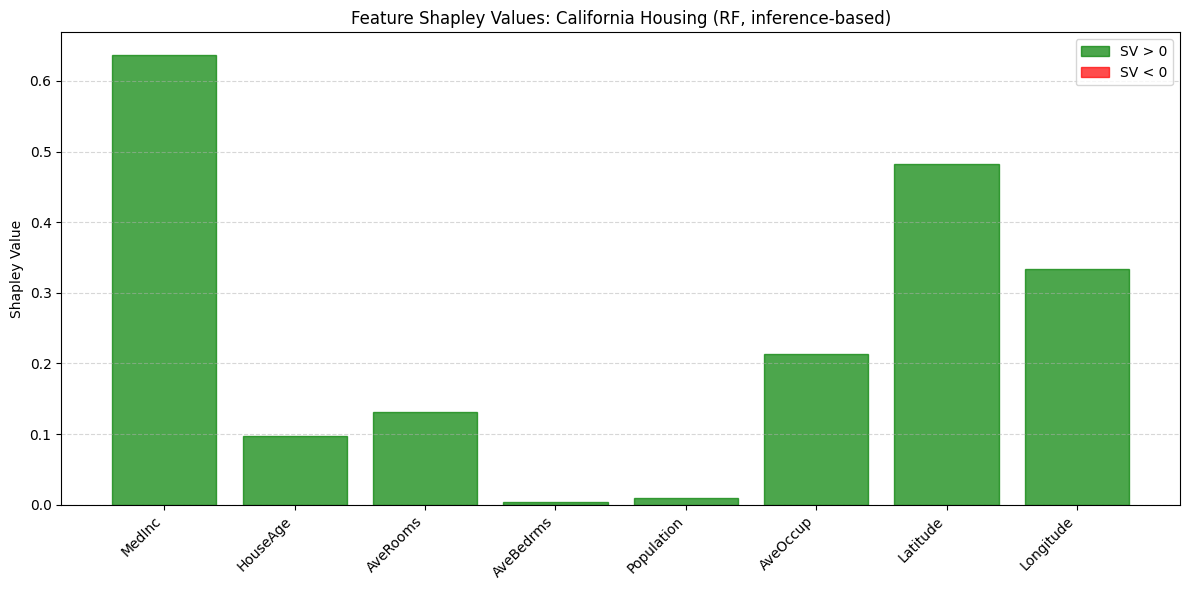

In [19]:
import matplotlib.pyplot as plt

fig_bar = plot_shapley_bar(
    sv_vals, labels,
    title="Feature Shapley Values: California Housing (RF, inference-based)",
)
plt.show()

### Pie chart
Relative share of each feature's $|\phi_i|$ in the total importance budget.

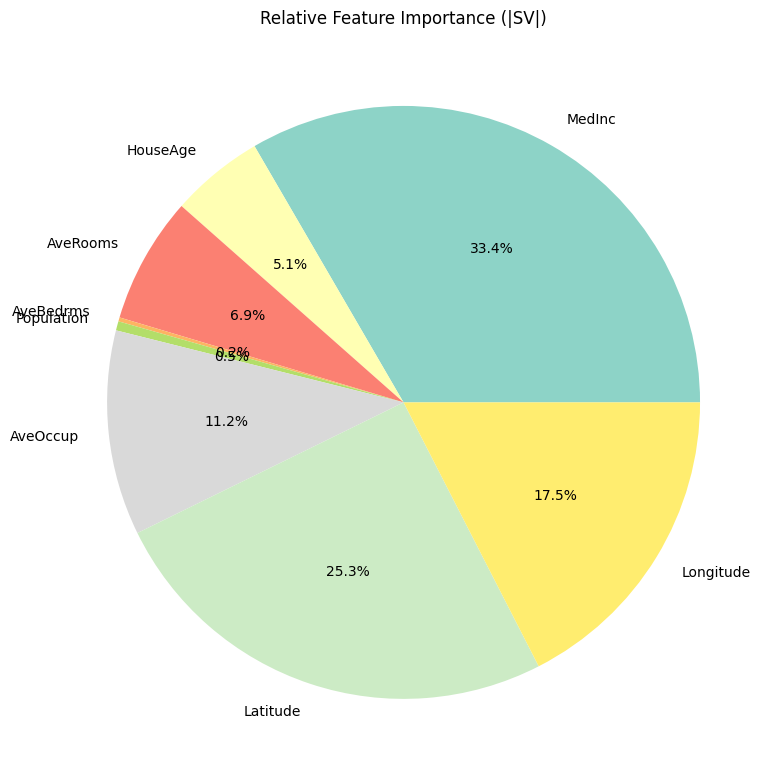

In [20]:
import matplotlib.pyplot as plt

fig_pie = plot_shapley_pie(
    sv_vals, labels,
    title="Relative Feature Importance (|SV|)",
)
plt.show()

## 7. Marginal contributions vs. Shapley values

The marginal contribution $v(\{i\}) - v(\emptyset)$ measures each feature **in isolation**.
Shapley values account for **interactions** between features.
Let's compare both side by side.

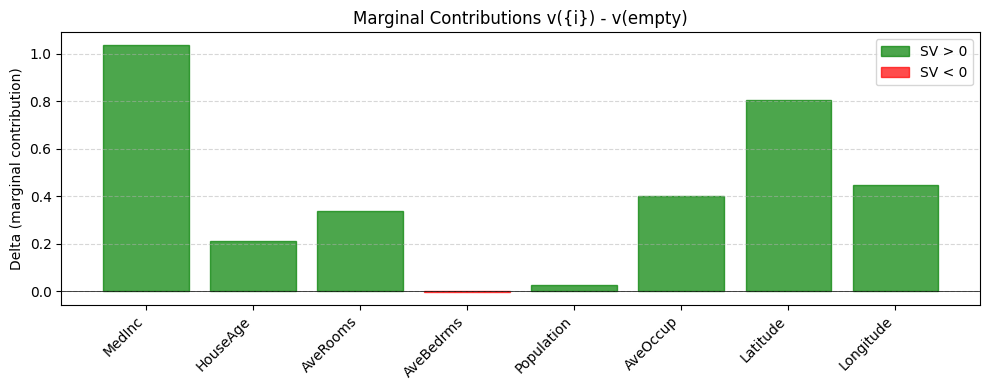

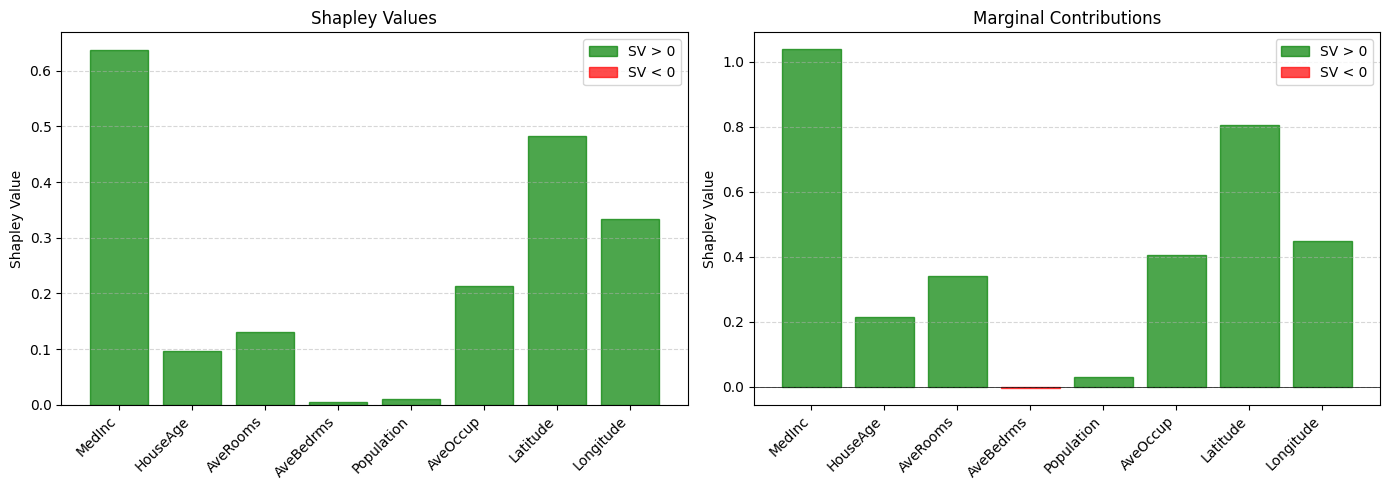

In [21]:
mc = sv.marginal_contributions()

fig_mc = plot_marginal_contributions(
    mc["deltas"], mc["player_labels"],
    title="Marginal Contributions v({i}) - v(empty)",
)
plt.show()

# Side-by-side comparison
fig_cmp = plot_shapley_comparison(
    [results, {"shapley_values": mc["deltas"], "player_labels": labels}],
    titles=["Shapley Values", "Marginal Contributions"],
)
plt.show()

## 8. Efficiency axiom check

A key property of Shapley values: the sum of all players' values equals $v(N) - v(\emptyset)$.

$$\sum_{i=1}^{n} \phi_i = v(N) - v(\emptyset)$$

Let's verify this holds.

In [22]:
v_grand = value_fn(list(range(len(feature_names))))
v_empty = value_fn([])
sv_sum  = sv_vals.sum()

print(f"v(N)            = {v_grand:.6f}")
print(f"v(empty)        = {v_empty:.6f}")
print(f"v(N) - v(empty) = {v_grand - v_empty:.6f}")
print(f"Sum phi_i       = {sv_sum:.6f}")
print(f"Difference      = {abs(sv_sum - (v_grand - v_empty)):.2e}  OK")

v(N)            = 0.805123
v(empty)        = -1.102675
v(N) - v(empty) = 1.907798
Sum phi_i       = 1.907798
Difference      = 2.22e-16  OK


## 9. Comparison with KernelSHAP

Both methods explain the **same trained Random Forest** using the **same perturbation
strategy**: absent features are replaced by the **training-set mean** (mean imputation).

| Method | How it works |
|--------|-------------|
| **Exact SV** (sections 3-4) | Enumerates all $2^8$ coalitions exactly, mean-imputes absent features, measures $R^2$ |
| **KernelSHAP** | Approximates Shapley values via weighted linear regression on a subset of coalitions; returns **per-instance** attributions that we average for global importance |

The **only** difference is the Shapley value computation itself:
exact enumeration vs. KernelSHAP's sampling-based approximation.
Any gap in the comparison below is purely approximation error.

  0%|          | 0/200 [00:00<?, ?it/s]

Same RF, same perturbation -- Exact SV vs. KernelSHAP (normalized)


,Feature,Exact SV (normed),KernelSHAP (normed),Delta,|Delta|
0,MedInc,0.3338,0.2704,0.0635,0.0635
1,Longitude,0.1747,0.2154,-0.0408,0.0408
2,AveOccup,0.1117,0.1463,-0.0346,0.0346
3,HouseAge,0.0509,0.0336,0.0173,0.0173
4,AveBedrms,0.0022,0.0145,-0.0123,0.0123
5,AveRooms,0.0690,0.0572,0.0117,0.0117
6,Latitude,0.2527,0.2552,-0.0025,0.0025
7,Population,0.0050,0.0074,-0.0024,0.0024


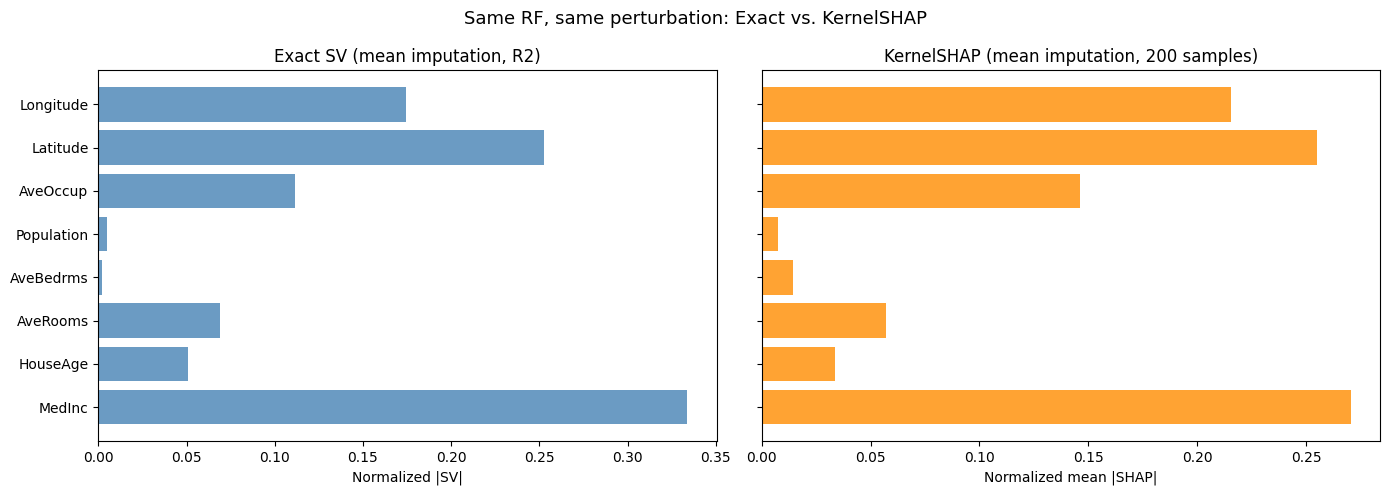


Max |Delta|:  0.0635  (feature: MedInc)
Mean |Delta|: 0.0231


In [24]:
import shap

# --- KernelSHAP on the same RF, same perturbation (mean imputation) ---
# Single-row background = training mean -> same masking as our exact SV
background = pd.DataFrame([X_mean], columns=feature_names)
explainer = shap.KernelExplainer(rf_full.predict, background)

# Explain 200 test samples, aggregate for global importance
X_test_sample = X_test.sample(200, random_state=42)
shap_values = explainer.shap_values(X_test_sample)
kernel_global = np.abs(shap_values).mean(axis=0)

# --- Reuse exact SVs from section 4 ---
exact_sv = results["shapley_values"]

# --- Normalize both to sum-to-1 for comparison ---
exact_norm = np.abs(exact_sv) / np.abs(exact_sv).sum()
kernel_norm = kernel_global / kernel_global.sum()

# --- Comparison table ---
df_cmp = pd.DataFrame({
    "Feature": feature_names,
    "Exact SV (normed)": exact_norm,
    "KernelSHAP (normed)": kernel_norm,
    "Delta": exact_norm - kernel_norm,
})
df_cmp["|Delta|"] = df_cmp["Delta"].abs()
df_cmp = df_cmp.sort_values("|Delta|", ascending=False).reset_index(drop=True)

print("Same RF, same perturbation -- Exact SV vs. KernelSHAP (normalized)")
print("=" * 65)
display(df_cmp.round(4))

# --- Side-by-side bar chart ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].barh(feature_names, exact_norm, color="steelblue", alpha=0.8)
axes[0].set_title("Exact SV (mean imputation, R2)")
axes[0].set_xlabel("Normalized |SV|")
axes[0].invert_yaxis()

axes[1].barh(feature_names, kernel_norm, color="darkorange", alpha=0.8)
axes[1].set_title("KernelSHAP (mean imputation, 200 samples)")
axes[1].set_xlabel("Normalized mean |SHAP|")
axes[1].invert_yaxis()

fig.suptitle("Same RF, same perturbation: Exact vs. KernelSHAP", fontsize=13)
fig.tight_layout()
plt.show()

print(f"\nMax |Delta|:  {df_cmp['|Delta|'].max():.4f}  (feature: {df_cmp.loc[0, 'Feature']})")
print(f"Mean |Delta|: {df_cmp['|Delta|'].mean():.4f}")